In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stroke-patiennts/data/val_data.csv
/kaggle/input/stroke-patiennts/data/train_data.csv
/kaggle/input/stroke-patiennts/data/test_data.csv


In [30]:
#Imports
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from tensorflow.keras.models import Sequential,Model
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,Dense,LSTM,Dropout,Conv1D,MaxPooling1D,Flatten,Bidirectional,TimeDistributed,Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf
warnings.filterwarnings('ignore')
FEATURES=16
TIMESTEPS=4
OUTPUT=1
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


In [31]:
train_df=pd.read_csv("/kaggle/input/stroke-patiennts/data/train_data.csv")
val_df=pd.read_csv("/kaggle/input/stroke-patiennts/data/val_data.csv")
test_df=pd.read_csv('/kaggle/input/stroke-patiennts/data/test_data.csv')

In [32]:
print(train_df.columns)
print(train_df.shape)

Index(['HADM_ID', 'SUBJECT_ID', 'GENDER', 'AGE', 'Admission Weight (Kg)',
       'Height (cm)', 'Heart Rate', 'Non Invasive Blood Pressure diastolic',
       'Non Invasive Blood Pressure mean',
       'Non Invasive Blood Pressure systolic', 'Respiratory Rate', 'stroke',
       'Tachycardia', 'Bradycardia', 'Hypertension', 'Hypotension',
       'Tachypnea', 'Bradypnea'],
      dtype='object')
(207408, 18)


In [33]:
new_columns = [col for col in train_df.columns if col != 'stroke'] + ['stroke']
print(new_columns)

['HADM_ID', 'SUBJECT_ID', 'GENDER', 'AGE', 'Admission Weight (Kg)', 'Height (cm)', 'Heart Rate', 'Non Invasive Blood Pressure diastolic', 'Non Invasive Blood Pressure mean', 'Non Invasive Blood Pressure systolic', 'Respiratory Rate', 'Tachycardia', 'Bradycardia', 'Hypertension', 'Hypotension', 'Tachypnea', 'Bradypnea', 'stroke']


In [34]:
train_df=train_df[new_columns]
val_df=val_df[new_columns]
test_df=test_df[new_columns]

In [35]:
train_df

,HADM_ID,SUBJECT_ID,GENDER,AGE,Admission Weight (Kg),Height (cm),Heart Rate,Non Invasive Blood Pressure diastolic,Non Invasive Blood Pressure mean,Non Invasive Blood Pressure systolic,Respiratory Rate,Tachycardia,Bradycardia,Hypertension,Hypotension,Tachypnea,Bradypnea,stroke
0,100018,58128,0,55,125.0,178.0,65.5,70.2,81.8,122.4,14.00,0,0,0,0,0,0,0
1,100018,58128,0,55,125.0,178.0,66.0,70.2,81.8,122.4,15.75,0,0,0,0,0,0,0
2,100018,58128,0,55,125.0,178.0,70.0,70.2,81.8,122.4,15.75,0,0,0,0,0,0,0
3,100018,58128,0,55,125.0,178.0,82.5,69.4,81.6,123.2,15.00,0,0,0,0,0,0,0
4,100018,58128,0,55,125.0,178.0,99.0,69.4,80.8,124.0,17.50,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207403,178565,46857,1,86,80.0,160.0,69.0,44.6,46.0,127.0,22.00,0,0,0,0,1,0,0
207404,178565,46857,1,86,80.0,160.0,64.0,49.0,73.0,142.0,24.00,0,0,0,0,1,0,0
207405,178565,46857,1,86,80.0,160.0,66.0,43.0,67.0,132.0,16.00,0,0,0,0,0,0,0
207406,178565,46857,1,86,80.0,160.0,67.0,69.6,86.4,140.0,22.00,0,0,0,0,1,0,0


In [8]:
train_df['stroke'].value_counts(normalize=True)

0    0.966983
1    0.033017
Name: stroke, dtype: float64

In [36]:
from sklearn.preprocessing import StandardScaler,RobustScaler
def static_scale(df):
    data=df.copy()
    scaler=RobustScaler()
    static_cols=["AGE",'Admission Weight (Kg)',"Height (cm)"]
    data[static_cols]=scaler.fit_transform(data[static_cols])
    return data,scaler

In [37]:
from sklearn.preprocessing import StandardScaler,RobustScaler
from tqdm import tqdm
def dynamic_scale(df):
    final_df=pd.DataFrame()
    cols=['Heart Rate',
                  'Non Invasive Blood Pressure diastolic', 'Non Invasive Blood Pressure mean',
                 'Non Invasive Blood Pressure systolic', 'Respiratory Rate']
    for hadm in tqdm(df['HADM_ID'].unique()):
        scaler=RobustScaler()
        #extract the dataframe
        hadm_df=df[df['HADM_ID']==hadm]
        #scale the float cols
        hadm_df[cols]=scaler.fit_transform(hadm_df[cols])
#         print(hadm_df)
        final_df = pd.concat([final_df,hadm_df])
    return final_df

In [38]:
static_cols=["AGE",'Admission Weight (Kg)',"Height (cm)"]
scaled_train,scaler=static_scale(train_df)
val_df[static_cols]=scaler.transform(val_df[static_cols])
test_df[static_cols]=scaler.transform(test_df[static_cols])

In [39]:
scaled_train=dynamic_scale(scaled_train)
val_df=dynamic_scale(val_df)
test_df=dynamic_scale(test_df)

100%|██████████| 216/216 [00:01<00:00, 144.21it/s]


In [40]:
#apply this function for eacxh unique admission
#so we won't mix timestamps from different admission in the same training sequence
def create_window(df):
    n_observation=4
    n_forecast=2
    n_target=1
    X,y=[],[]
    for adm_id in tqdm(df['HADM_ID'].unique()):
        data=df[df['HADM_ID']==adm_id]
#         target_cols=["stroke"]
#         target_df=data[target_cols]
    #     data.drop(target_cols,axis=1,inplace=True)
        for i in range(len(data)-8):
            X.append(data.iloc[i:i+n_observation,2:])
            y.append(data.iloc[i+n_observation+n_forecast:i+n_observation+n_forecast+n_target,-1])
    return np.array(X),np.array(y)

In [41]:
neg,pos=np.bincount(train_df['stroke'])
total=neg+pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Examples:
    Total: 207408
    Positive: 6848 (3.30% of total)

Weight for class 0: 0.52
Weight for class 1: 15.14


In [42]:
X_train,y_train=create_window(scaled_train)
X_val,y_val=create_window(val_df)
X_test,y_test=create_window(test_df)
print(X_train.shape," ",y_train.shape)
print(X_val.shape," ",y_val.shape)
print(X_test.shape," ",y_test.shape)

100%|██████████| 216/216 [00:09<00:00, 22.87it/s]


(194376, 4, 16)   (194376, 1)
(24153, 4, 16)   (24153, 1)
(24164, 4, 16)   (24164, 1)


In [43]:
#extracting static feats
X_train_static=X_train[:, 0, :4]
X_val_static=X_val[:,0,:4]
X_test_static=X_test[:,0,:4]

In [44]:
def clean_preds(model,data):
    real_predictions=[]
    predictions=model.predict(data)
    for pred in predictions:
        if pred > 0.5:
            real_predictions.append(1)
        else:
            real_predictions.append(0)
    return np.array(real_predictions)

In [45]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import seaborn as sns
def plot_cm (real,preds):
    plt.figure(figsize=(6,6))
    cm = confusion_matrix(real,preds)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in  cm.flatten()] 
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in  zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm,annot=labels,fmt="",cmap='Blues')
    print(classification_report(real, preds))
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
#     plt.title('STEP 1')

## Hyperparameters tunning using Keras-Tuner

In [18]:
! pip install keras-tuner

### print the model architecture

In [19]:
# RNN + SLP
n_static=4
n_timesteps=4
n_dynamic=12
n_output=1

#Define input layer
recurrent_input = Input(shape=(n_timesteps,n_dynamic),name="TIMESERIES_INPUT")
static_input = Input(shape=(n_static, ),name="STATIC_INPUT")

# RNN Layers
# layer - 1
rec_layer_one = Bidirectional(LSTM(128, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01),return_sequences=True),name ="BIDIRECTIONAL_LAYER_1")(recurrent_input)
rec_layer_one = Dropout(0.1,name ="DROPOUT_LAYER_1")(rec_layer_one)
# layer - 2
rec_layer_two = Bidirectional(LSTM(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)),name ="BIDIRECTIONAL_LAYER_2")(rec_layer_one)
rec_layer_two = Dropout(0.1,name ="DROPOUT_LAYER_2")(rec_layer_two)

# SLP Layers
static_layer_one = Dense(64,  kernel_regularizer=l2(0.001),  activation='relu',name="DENSE_LAYER_1")(static_input)
# Combine layers - RNN + SLP
combined = Concatenate(axis= 1,name = "CONCATENATED_TIMESERIES_STATIC")([rec_layer_two,static_layer_one])
combined_dense_two = Dense(64, activation='relu',name="DENSE_LAYER_2")(combined)
output = Dense(n_output,activation='sigmoid',name="OUTPUT_LAYER")(combined_dense_two)

# Compile ModeL
model = keras.Model(inputs=[recurrent_input,static_input],outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 TIMESERIES_INPUT (InputLayer)  [(None, 4, 12)]      0           []                               
                                                                                                  
 BIDIRECTIONAL_LAYER_1 (Bidirec  (None, 4, 256)      144384      ['TIMESERIES_INPUT[0][0]']       
 tional)                                                                                          
                                                                                                  
 DROPOUT_LAYER_1 (Dropout)      (None, 4, 256)       0           ['BIDIRECTIONAL_LAYER_1[0][0]']  
                                                                                                  
 BIDIRECTIONAL_LAYER_2 (Bidirec  (None, 128)         164352      ['DROPOUT_LAYER_1[0][0]']    

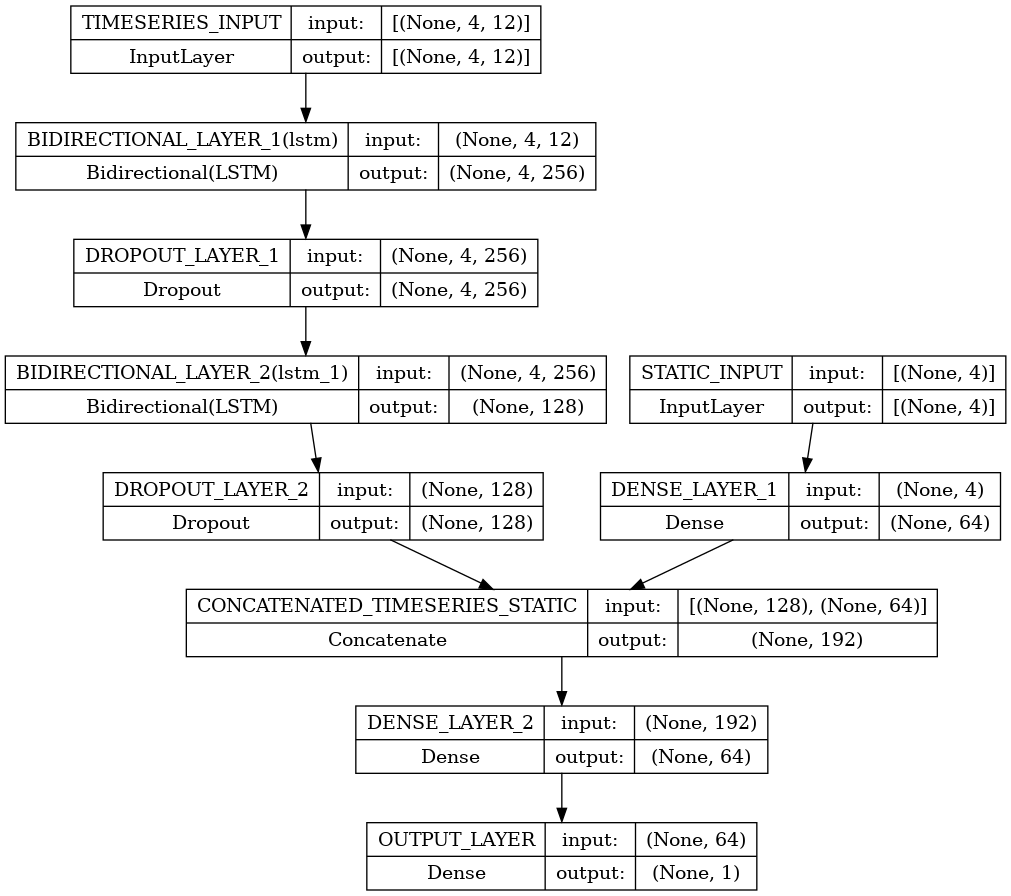

In [21]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='/kaggle/working/model_plot.png', show_shapes=True, show_layer_names=True)

#### Objective: recall maximization

- forget to add class weights

In [46]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from kerastuner.tuners import RandomSearch
from kerastuner import Objective

def build_model(hp):
    # ... [rest of the code remains unchanged]
    n_static = 4
    n_timesteps = 4
    n_dynamic = 12
    n_output = 1

    recurrent_input = keras.Input(shape=(n_timesteps, n_dynamic), name="TIMESERIES_INPUT")
    static_input = keras.Input(shape=(n_static, ), name="STATIC_INPUT")

    rec_layer_one = layers.Bidirectional(layers.LSTM(
        units=hp.Int('lstm_units_1', min_value=64, max_value=256, step=32),
        kernel_regularizer=l2(hp.Choice('l2_1', values=[0.01, 0.001, 0.0001])),
        recurrent_regularizer=l2(hp.Choice('l2_2', values=[0.01, 0.001, 0.0001])),
        return_sequences=True
    ), name="BIDIRECTIONAL_LAYER_1")(recurrent_input)
    rec_layer_one = layers.Dropout(hp.Choice('dropout_1', values=[0.1, 0.2, 0.3]), name="DROPOUT_LAYER_1")(rec_layer_one)

    rec_layer_two = layers.Bidirectional(layers.LSTM(
        units=hp.Int('lstm_units_2', min_value=32, max_value=128, step=32),
        kernel_regularizer=l2(hp.Choice('l2_3', values=[0.01, 0.001, 0.0001])),
        recurrent_regularizer=l2(hp.Choice('l2_4', values=[0.01, 0.001, 0.0001]))
    ), name="BIDIRECTIONAL_LAYER_2")(rec_layer_one)
    rec_layer_two = layers.Dropout(hp.Choice('dropout_2', values=[0.1, 0.2, 0.3]), name="DROPOUT_LAYER_2")(rec_layer_two)

    static_layer_one = layers.Dense(
        units=hp.Int('dense_units_1', min_value=32, max_value=128, step=32),
        kernel_regularizer=l2(hp.Choice('l2_5', values=[0.01, 0.001, 0.0001])),
        activation=hp.Choice('activation_1', values=['relu', 'tanh']),
        name="DENSE_LAYER_1"
    )(static_input)

    combined = layers.Concatenate(axis=1, name="CONCATENATED_TIMESERIES_STATIC")([rec_layer_two, static_layer_one])
    combined_dense_two = layers.Dense(
        units=hp.Int('dense_units_2', min_value=32, max_value=128, step=32),
        activation=hp.Choice('activation_2', values=['relu', 'tanh']),
        name="DENSE_LAYER_2"
    )(combined)

    output = layers.Dense(n_output, activation='sigmoid', name="OUTPUT_LAYER")(combined_dense_two)

    model = keras.Model(inputs=[recurrent_input, static_input], outputs=[output])
    model.compile(
        loss='binary_crossentropy', 
        optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[0.001, 0.01, 0.1])),
        metrics=[
            keras.metrics.BinaryAccuracy(name='accuracy'),
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='auc'),
            keras.metrics.AUC(name='prc', curve='PR')
        ]
    )
    return model

# Early stopping for recall
early_stopping_recall = keras.callbacks.EarlyStopping(
    monitor='val_recall',
    patience=5,
    mode='max',
    verbose=1,
    restore_best_weights=True
)

# Model checkpoint for recall
checkpoint_recall = keras.callbacks.ModelCheckpoint(
    "best_weights_recall.h5", 
    monitor='val_recall', 
    verbose=1, 
    save_best_only=True, 
    mode='max'
)

callbacks_list = [early_stopping_recall, checkpoint_recall]

tuner = RandomSearch(
    build_model,
    objective=Objective('val_recall', direction='max'),
    max_trials=10,
    directory='tuning_dir',
    project_name='keras_tuner_example'
)

tuner.search(
    x=[X_train[:, :, 4:], X_train_static], 
    y=y_train,
    epochs=30,
    batch_size=32,
    validation_data=([X_val[:, :, 4:], X_val_static], y_val),
    callbacks=callbacks_list,
    class_weight=class_weight
)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Save the best model
best_model.save("best_model_recall.h5")


756/756 [==============================] - 7s 6ms/step - loss: 0.1624 - accuracy: 0.9681 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0319
Model from best_weights_recall.h5:
Loss: 0.1624, Accuracy: 0.9681, Precision: 0.0000, Recall: 0.0000, AUC: 0.5000, PRC: 0.0319
756/756 [==============================] - 4s 4ms/step
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     23394
           1       0.00      0.00      0.00       770

    accuracy                           0.97     24164
   macro avg       0.48      0.50      0.49     24164
weighted avg       0.94      0.97      0.95     24164

756/756 [==============================] - 7s 6ms/step - loss: 0.1492 - accuracy: 0.9634 - precision: 0.4017 - recall: 0.3026 - auc: 0.8522 - prc: 0.2820
Model from best_model_recall.h5:
Loss: 0.1492, Accuracy: 0.9634, Precision: 0.4017, Recall: 0.3026, AUC: 0.8522, PRC: 0.2820
756/756 [==============================] - 4s 4ms/

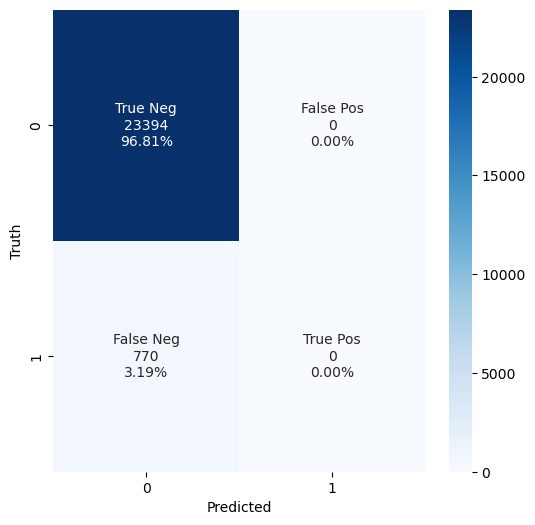

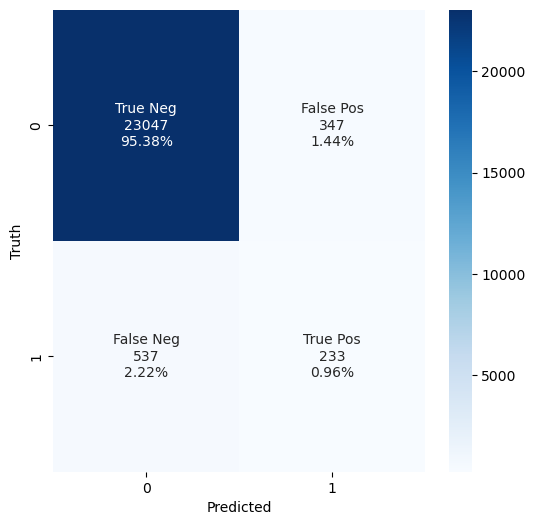

In [22]:
# Load your saved models and evaluate them from recall maximization experiment
saved_models_recall = ["best_weights_recall.h5", "best_model_recall.h5"]  # Adjust based on your filenames

for model_path in saved_models_recall:
    # Load the model
    model = keras.models.load_model(model_path)
    
    # Evaluate using TensorFlow's built-in method
    loss, accuracy, precision, recall, auc, prc = model.evaluate([X_test[:, :, 4:], X_test_static], y_test)
    print(f"Model from {model_path}:")
    print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, AUC: {auc:.4f}, PRC: {prc:.4f}")
    
    # Predict and use your custom functions
    preds = clean_preds(model, [X_test[:, :, 4:], X_test_static])
    plot_cm(y_test, preds)

#### Objective: loss minimization

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from kerastuner.tuners import RandomSearch
from kerastuner import Objective

def build_model(hp):
    # ... [rest of the code remains unchanged]
    n_static = 4
    n_timesteps = 4
    n_dynamic = 12
    n_output = 1

    recurrent_input = keras.Input(shape=(n_timesteps, n_dynamic), name="TIMESERIES_INPUT")
    static_input = keras.Input(shape=(n_static, ), name="STATIC_INPUT")

    rec_layer_one = layers.Bidirectional(layers.LSTM(
        units=hp.Int('lstm_units_1', min_value=64, max_value=256, step=32),
        kernel_regularizer=l2(hp.Choice('l2_1', values=[0.01, 0.001, 0.0001])),
        recurrent_regularizer=l2(hp.Choice('l2_2', values=[0.01, 0.001, 0.0001])),
        return_sequences=True
    ), name="BIDIRECTIONAL_LAYER_1")(recurrent_input)
    rec_layer_one = layers.Dropout(hp.Choice('dropout_1', values=[0.1, 0.2, 0.3]), name="DROPOUT_LAYER_1")(rec_layer_one)

    rec_layer_two = layers.Bidirectional(layers.LSTM(
        units=hp.Int('lstm_units_2', min_value=32, max_value=128, step=32),
        kernel_regularizer=l2(hp.Choice('l2_3', values=[0.01, 0.001, 0.0001])),
        recurrent_regularizer=l2(hp.Choice('l2_4', values=[0.01, 0.001, 0.0001]))
    ), name="BIDIRECTIONAL_LAYER_2")(rec_layer_one)
    rec_layer_two = layers.Dropout(hp.Choice('dropout_2', values=[0.1, 0.2, 0.3]), name="DROPOUT_LAYER_2")(rec_layer_two)

    static_layer_one = layers.Dense(
        units=hp.Int('dense_units_1', min_value=32, max_value=128, step=32),
        kernel_regularizer=l2(hp.Choice('l2_5', values=[0.01, 0.001, 0.0001])),
        activation=hp.Choice('activation_1', values=['relu', 'tanh']),
        name="DENSE_LAYER_1"
    )(static_input)

    combined = layers.Concatenate(axis=1, name="CONCATENATED_TIMESERIES_STATIC")([rec_layer_two, static_layer_one])
    combined_dense_two = layers.Dense(
        units=hp.Int('dense_units_2', min_value=32, max_value=128, step=32),
        activation=hp.Choice('activation_2', values=['relu', 'tanh']),
        name="DENSE_LAYER_2"
    )(combined)

    output = layers.Dense(n_output, activation='sigmoid', name="OUTPUT_LAYER")(combined_dense_two)

    model = keras.Model(inputs=[recurrent_input, static_input], outputs=[output])
    model.compile(
        loss='binary_crossentropy', 
        optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[0.001, 0.01, 0.1])),
        metrics=[
            keras.metrics.BinaryAccuracy(name='accuracy'),
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='auc'),
            keras.metrics.AUC(name='prc', curve='PR')
        ]
    )
    return model

# Early stopping for val_loss
early_stopping_loss = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    verbose=1,
    restore_best_weights=True
)

# Model checkpoint for val_loss
checkpoint_loss = keras.callbacks.ModelCheckpoint(
    "best_weights_loss.h5", 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    mode='min'
)

callbacks_list = [early_stopping_loss, checkpoint_loss]

tuner = RandomSearch(
    build_model,
    objective=Objective('val_loss', direction='min'),
    max_trials=10,
    directory='tuning_dir',
    project_name='keras_tuner_example'
)

tuner.search(
    x=[X_train[:, :, 4:], X_train_static], 
    y=y_train,
    epochs=30,
    batch_size=32,
    validation_data=([X_val[:, :, 4:], X_val_static], y_val),
    callbacks=callbacks_list,
    class_weight=class_weight
)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Save the best model
best_model.save("best_model_loss.h5")


Trial 10 Complete [00h 29m 13s]
val_loss: 0.3197416663169861

Best val_loss So Far: 0.18706418573856354
Total elapsed time: 02h 34m 15s


756/756 [==============================] - 6s 6ms/step - loss: 0.1431 - accuracy: 0.9681 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0319
Model from best_model_loss.h5:
Loss: 0.1431, Accuracy: 0.9681, Precision: 0.0000, Recall: 0.0000, AUC: 0.5000, PRC: 0.0319
756/756 [==============================] - 4s 4ms/step
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     23394
           1       0.00      0.00      0.00       770

    accuracy                           0.97     24164
   macro avg       0.48      0.50      0.49     24164
weighted avg       0.94      0.97      0.95     24164

756/756 [==============================] - 7s 7ms/step - loss: 0.3086 - accuracy: 0.8889 - precision: 0.1808 - recall: 0.7039 - auc: 0.8715 - prc: 0.3046
Model from best_weights_loss.h5:
Loss: 0.3086, Accuracy: 0.8889, Precision: 0.1808, Recall: 0.7039, AUC: 0.8715, PRC: 0.3046
756/756 [==============================] - 4s 4ms/step

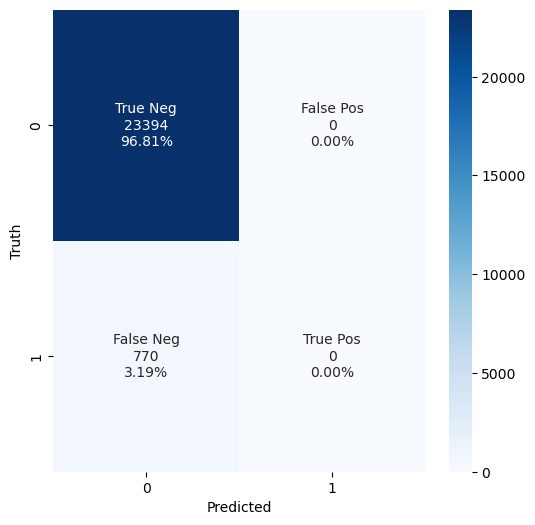

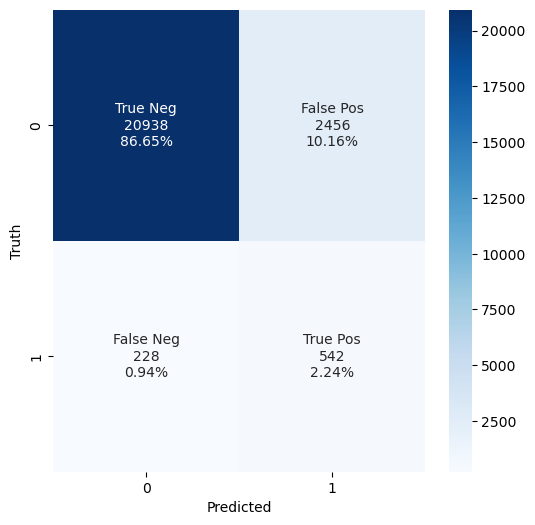

In [23]:
# Load your saved models and evaluate them
saved_models = ["best_model_loss.h5", "best_weights_loss.h5"]  # Adjust based on your filenames

for model_path in saved_models:
    # Load the model
    model = keras.models.load_model(model_path)
    
    # Evaluate using TensorFlow's built-in method
    loss, accuracy, precision, recall, auc, prc = model.evaluate([X_test[:, :, 4:], X_test_static], y_test)
    print(f"Model from {model_path}:")
    print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, AUC: {auc:.4f}, PRC: {prc:.4f}")
    
    # Predict and use your custom functions
    preds = clean_preds(model, [X_test[:, :, 4:], X_test_static])
    plot_cm(y_test, preds)